In [2]:
from manim import *
from sympy.physics.units import force

from figures.manim_custom import *
from manim_mobject_svg import *
from figures.manim_custom.models import BinaryTree

import os

memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results"

quality = "ql"
config['background_color'] = WHITE

import numpy as np

try:
    import openseespy.opensees as ops


    def analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A_list, E_list):
        """
        Parameters:
            nodes: np.array of shape (n_nodes, 3)
            connectivity_matrix: np.array of shape (n_elements, 2)
            supports: dict {node_index: (fix_x, fix_y)}
            loads: dict {node_index: [Fx, Fy]}
            A_list: list of cross-sectional areas (length = n_elements)
            E_list: list of Young's moduli (length = n_elements)

        Returns:
            displacements: dict {node_index: [ux, uy]}
        """

        ops.wipe()
        ops.model('basic', '-ndm', 2, '-ndf', 2)

        # Create nodes
        for i, (x, y, _) in enumerate(nodes):
            ops.node(i, x, y)

        # Supports
        for node_id, (fix_x, fix_y) in supports.items():
            ops.fix(node_id, int(fix_x), int(fix_y))

        # Define elements and materials
        for i, (ni, nj) in enumerate(connectivity_matrix):
            E = E_list[i]
            A = A_list[i]
            ops.uniaxialMaterial("Elastic", i, E)
            ops.element("truss", i, int(ni), int(nj), A, i)

        # Apply loads
        ops.timeSeries("Linear", 1)
        ops.pattern("Plain", 1, 1)
        for node_id, (Fx, Fy) in loads.items():
            ops.load(node_id, Fx, Fy)

        # Static analysis
        ops.system("SparseGeneral")
        ops.numberer("RCM")
        ops.constraints("Plain")
        ops.integrator("LoadControl", 1.0)
        ops.algorithm("Linear")
        ops.analysis("Static")
        ops.analyze(1)

        # Get displacements
        displacements = np.array([
            [ops.nodeDisp(i, 1), ops.nodeDisp(i, 2)]
            for i in range(len(nodes))
        ])

        forces = np.array([ops.eleResponse(i, 'axialForce')[0] for i in range(len(connectivity_matrix))])

        return displacements, forces
except Exception:
    pass


In [2]:
class BridgeUsage(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(2)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [(0, 0, 0), (5, 0, 0), (10, 0, 0), (15, 0, 0), (20, 0, 0), (25, 0, 0), (30, 0, 0), (35, 0, 0), (40, 0, 0),
             (35, 5, 0), (30, 5, 0), (25, 5, 0), (20, 5, 0), (15, 5, 0), (10, 5, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 8: (True, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8),
                                        (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 0),
                                        (1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9),
                                        (2, 15), (3, 14), (4, 13), (4, 11), (5, 10), (6, 9)])
        loads = {
            2: [0., -500e3],
            3: [0., -1000e3],
            4: [0., -500e3],
        }
        loads = {}

        A = [.1] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)

        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_color': BLACK, 'stroke_width': 4},
                  node_style={'radius': .15, 'color': DARK_GRAY},
                  support_style={'height': 1.3, 'color': DARK_GRAY},
                  load_style={'scale': 4},
                  tip_style={'tip_length': .75, 'tip_width': .65},
                  deformed_style={'dash_length': .25, 'stroke_width': 8},
                  display_node_labels=False,
                  display_load_labels=False,
                  display_member_labels=False)

        g.move_to(ORIGIN)
        #g.overlap_deformation(100)
        #g.update()

        #for load in g.loads:
        #    self.bring_to_front(load)

        car = SVGMobject("figures/ref_img/car.svg")
        car.scale(2 / car.height)
        self.add(g, car)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(.5)
        path = "test"
        all_group.to_svg(path, crop=True)

        car.next_to(g.members[0], UP, buff=0).shift((5 + car.width) * LEFT)
        car_move = car.animate.next_to(g.members[7].get_center() + (5 + car.width) * RIGHT, UP, buff=0.)
        self.wait(.2)
        self.play(car_move, run_time=4, rate_func=rate_functions.linear)
        self.wait(.2)

%manim --transparent --format webm --fps 30 -qk -v WARNING BridgeUsage

Manim Community v0.19.0

[08/21/25 17:37:37] WARNING  Output format changed to '.webm' to support transparency                 ]8;id=213246;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=527246;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

                    WARNING  Output format set as webm, this can be slower than other formats         ]8;id=276116;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=119882;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1052\1052]8;;\

Manim Community v0.19.0

[08/21/25 17:37:59] WARNING  Output format changed to '.mov' to support transparency                  ]8;id=77293;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=339217;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

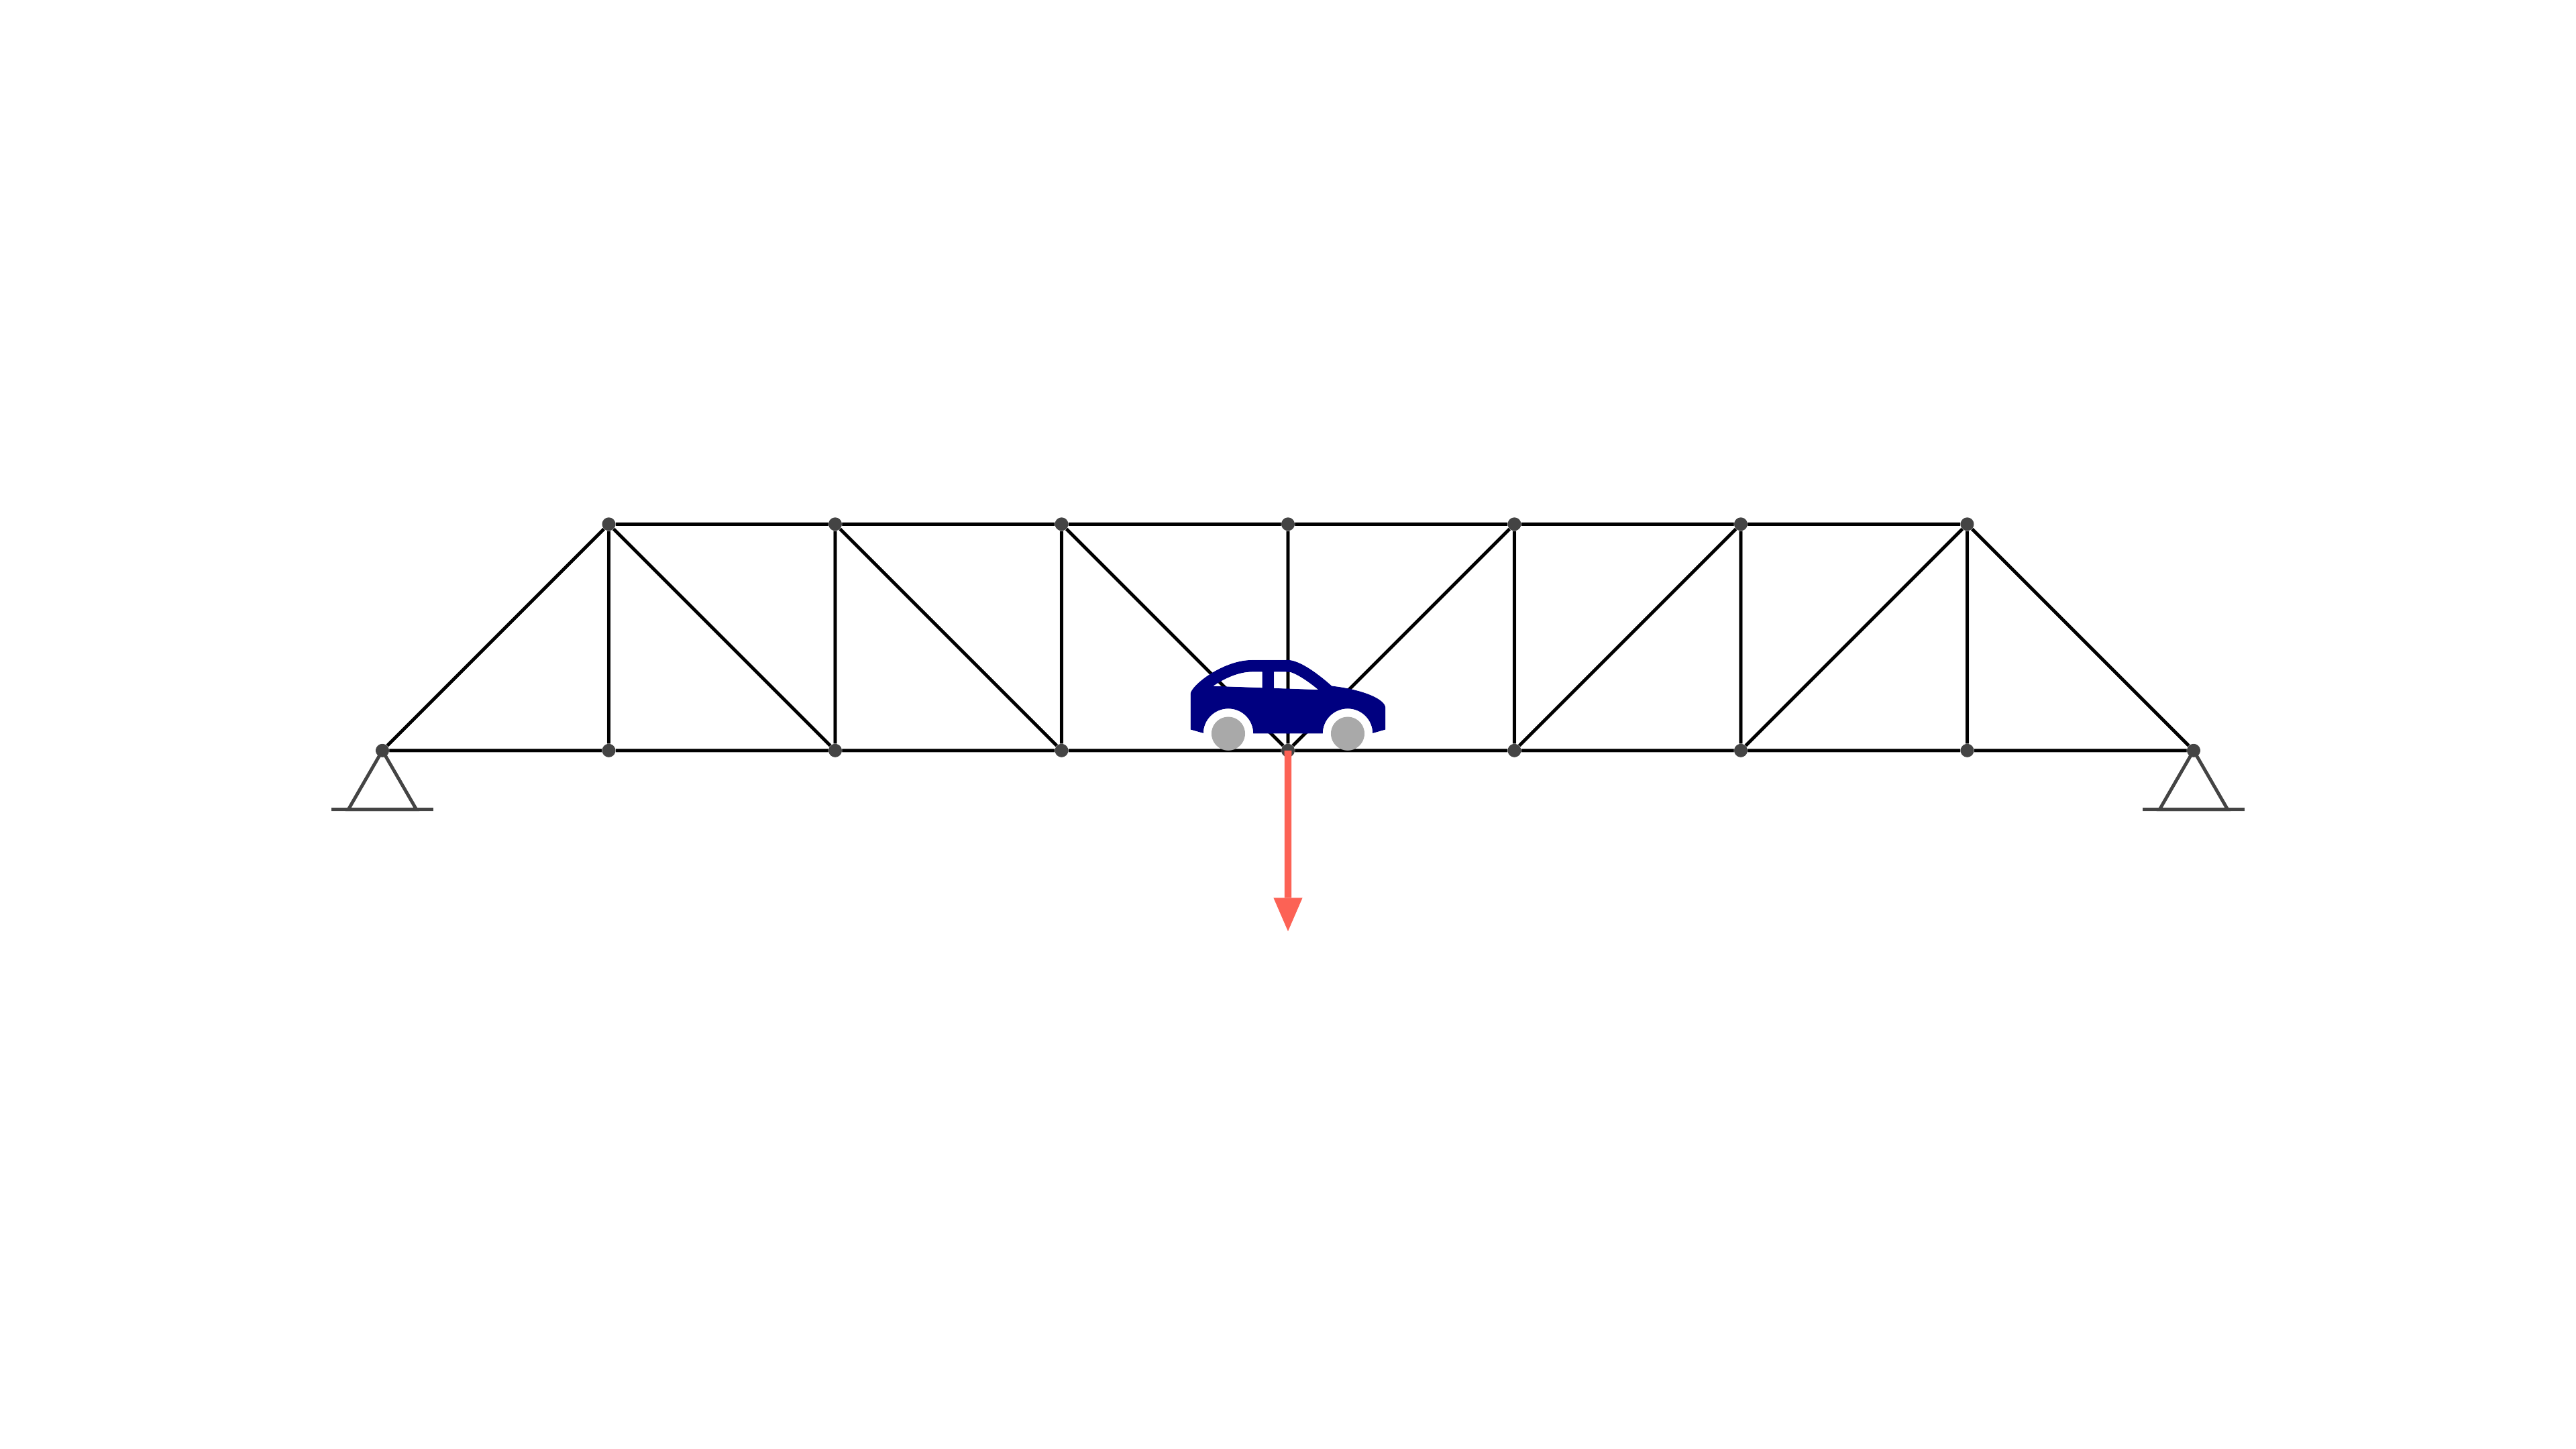

In [3]:
class BridgeDesign1(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(2)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [(0, 0, 0), (5, 0, 0), (10, 0, 0), (15, 0, 0), (20, 0, 0), (25, 0, 0), (30, 0, 0), (35, 0, 0), (40, 0, 0),
             (35, 5, 0), (30, 5, 0), (25, 5, 0), (20, 5, 0), (15, 5, 0), (10, 5, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 8: (True, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8),
                                        (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 0),
                                        (1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9),
                                        (2, 15), (3, 14), (4, 13), (4, 11), (5, 10), (6, 9)])
        loads = {
            4: [0., -1000e3],
        }

        A = [.1] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)

        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_color': BLACK, 'stroke_width': 4},
                  node_style={'radius': .15, 'color': DARK_GRAY},
                  support_style={'height': 1.3, 'color': DARK_GRAY},
                  load_style={'scale': 4, 'stroke_width': 8},
                  tip_style={'tip_length': .75, 'tip_width': .65},
                  deformed_style={'dash_length': .25, 'stroke_width': 8},
                  display_node_labels=False,
                  display_load_labels=False,
                  display_member_labels=False)

        g.move_to(ORIGIN)
        #g.overlap_deformation(100)
        #g.update()

        #for load in g.loads:
        #    self.bring_to_front(load)

        car = SVGMobject("figures/ref_img/car.svg")
        car.scale(2 / car.height)
        self.add(g, car)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(.5)
        path = "test"
        all_group.to_svg(path, crop=True)
        car.next_to(g.nodes[4].get_center(), UP, buff=0)

%manim --transparent --format png --fps 30 -qk -v WARNING BridgeDesign1

In [21]:
class BridgeDesign2(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(2)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [(0, 0, 0), (5, 0, 0), (10, 0, 0), (15, 0, 0), (20, 0, 0), (25, 0, 0), (30, 0, 0), (35, 0, 0), (40, 0, 0),
             (35, 5, 0), (30, 5, 0), (25, 5, 0), (20, 5, 0), (15, 5, 0), (10, 5, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 8: (True, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8),
                                        (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 0),
                                        (1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9),
                                        (2, 15), (3, 14), (4, 13), (4, 11), (5, 10), (6, 9)])
        loads = {
            #3: [0, -500e3],
            4: [0., -1500e3],
            #5: [0., -500e3],
        }

        A = [.1] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
        N = N.round(0)
        font_size = 30
        g1 = Truss(nodes=nodes,
                   connectivity_matrix=connectivity_matrix,
                   supports=supports,
                   loads=loads,
                   displacements=u,
                   member_style={'stroke_color': BLACK, 'stroke_width': 4},
                   node_style={'radius': 0, 'color': DARK_GRAY},
                   support_style={'height': 1.3, 'color': DARK_GRAY},
                   load_style={'scale': 4, 'stroke_width': 8},
                   tip_style={'tip_length': .75, 'tip_width': .65},
                   deformed_style={'dash_length': .25, 'stroke_width': 8},
                   display_node_labels=False,
                   display_load_labels=False,
                   display_member_labels=False)

        g1.move_to(ORIGIN)
        g2 = g1.copy()

        g2.toggle_normal_forces(N, max_width=20)

        car = SVGMobject("figures/ref_img/car.svg")
        car.scale(2 / car.height)
        self.add(g1, car)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(.5)
        path = "test"
        all_group.to_svg(path, crop=True)
        car.next_to(g1.nodes[4].get_center(), UP, buff=0)

        for indices in [
            [3, 4, 19, 25, 26],  # ok
            [2, 24, 28, 12, 13, 11, 10, 20, 27, 5, 18],  # ok
            [14, 17, 23, 1, 9, 21, 28, 6],  # ok
            [0, 15, 16, 22, 8, 7],
        ]:
            bars = [g1.members[i] for i in indices]
            bars_N = [g2.members[i] for i in indices]

            animation = AnimationGroup(*[
                Transform(bar, bar_N) for bar, bar_N in zip(bars, bars_N)
            ])
            self.play(animation, run_time=1)

        force_1 = Line(ORIGIN, ORIGIN + 1 * UP, stroke_color=RED, stroke_width=8).next_to(g1.supports[0], DOWN, buff=0)
        force_1.add_tip(**{k: v / 2 for k, v in g1._tip_style.items()})
        force_2 = force_1.copy().next_to(g1.supports[1], DOWN, buff=0)

        self.play(FadeIn(force_1, force_2))
        self.wait(1)

%manim --transparent --format webm --fps 30 -qk -v WARNING BridgeDesign2
%manim --transparent --format png --fps 30 -qk -v WARNING BridgeDesign2

Manim Community v0.19.0

[08/21/25 18:01:24] WARNING  Output format changed to '.webm' to support transparency                 ]8;id=937965;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=55198;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

                    WARNING  Output format set as webm, this can be slower than other formats         ]8;id=985166;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=937210;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1052\1052]8;;\

Manim Community v0.19.0

[08/21/25 18:01:46] WARNING  Output format changed to '.mov' to support transparency                  ]8;id=579500;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=44068;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

In [5]:
class BridgeDesign3(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(2)
        self.camera.frame.move_to(ORIGIN)

    def construct(self):
        nodes = np.array(
            [(0, 0, 0), (5, 0, 0), (10, 0, 0), (15, 0, 0), (20, 0, 0), (25, 0, 0), (30, 0, 0), (35, 0, 0), (40, 0, 0),
             (35, 5, 0), (30, 5, 0), (25, 5, 0), (20, 5, 0), (15, 5, 0), (10, 5, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 8: (True, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8),
                                        (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 0),
                                        (1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9),
                                        (2, 15), (3, 14), (4, 13), (4, 11), (5, 10), (6, 9)])
        loads = {
            #3: [0, -500e3],
            4: [0., -1500e3],
            #5: [0., -500e3],
        }

        A = [.1] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
        N = N.round(0)
        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_color': BLACK, 'stroke_width': 4},
                  node_style={'radius': 0, 'color': DARK_GRAY},
                  support_style={'height': 1.3, 'color': DARK_GRAY},
                  load_style={'scale': 4, 'stroke_width': 8},
                  tip_style={'tip_length': .75, 'tip_width': .65},
                  deformed_style={'dash_length': .25, 'stroke_width': 8},
                  display_node_labels=False,
                  display_load_labels=False,
                  display_member_labels=False)

        g.move_to(ORIGIN)
        g.toggle_normal_forces(N, max_width=20)
        #g.overlap_deformation(100)
        #g.update()

        #for load in g.loads:
        #    self.bring_to_front(load)

        car = SVGMobject("figures/ref_img/car.svg")
        car.scale(2 / car.height)
        car.next_to(g.nodes[4], UP, buff=0)
        car.add_updater(lambda m: m.next_to(g.nodes[4], UP, buff=0))
        self.add(g, car)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(.5)

        t = 2
        animation = g.deform_structure(100, True)
        self.play(animation, run_time=t / 2)

        animation = g.deform_structure(-100, True)
        self.play(animation, run_time=t / 2)
        path = "test"
        all_group.to_svg(path, crop=True)

%manim --transparent --format webm --fps 30 -qk -v WARNING BridgeDesign3

Manim Community v0.19.0

[08/21/25 17:38:00] WARNING  Output format changed to '.webm' to support transparency                 ]8;id=618321;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=985148;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

                    WARNING  Output format set as webm, this can be slower than other formats         ]8;id=475444;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=23055;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1052\1052]8;;\

Manim Community v0.19.0

[08/23/25 21:40:10] WARNING  Output format changed to '.mov' to support transparency                  ]8;id=936566;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=609729;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

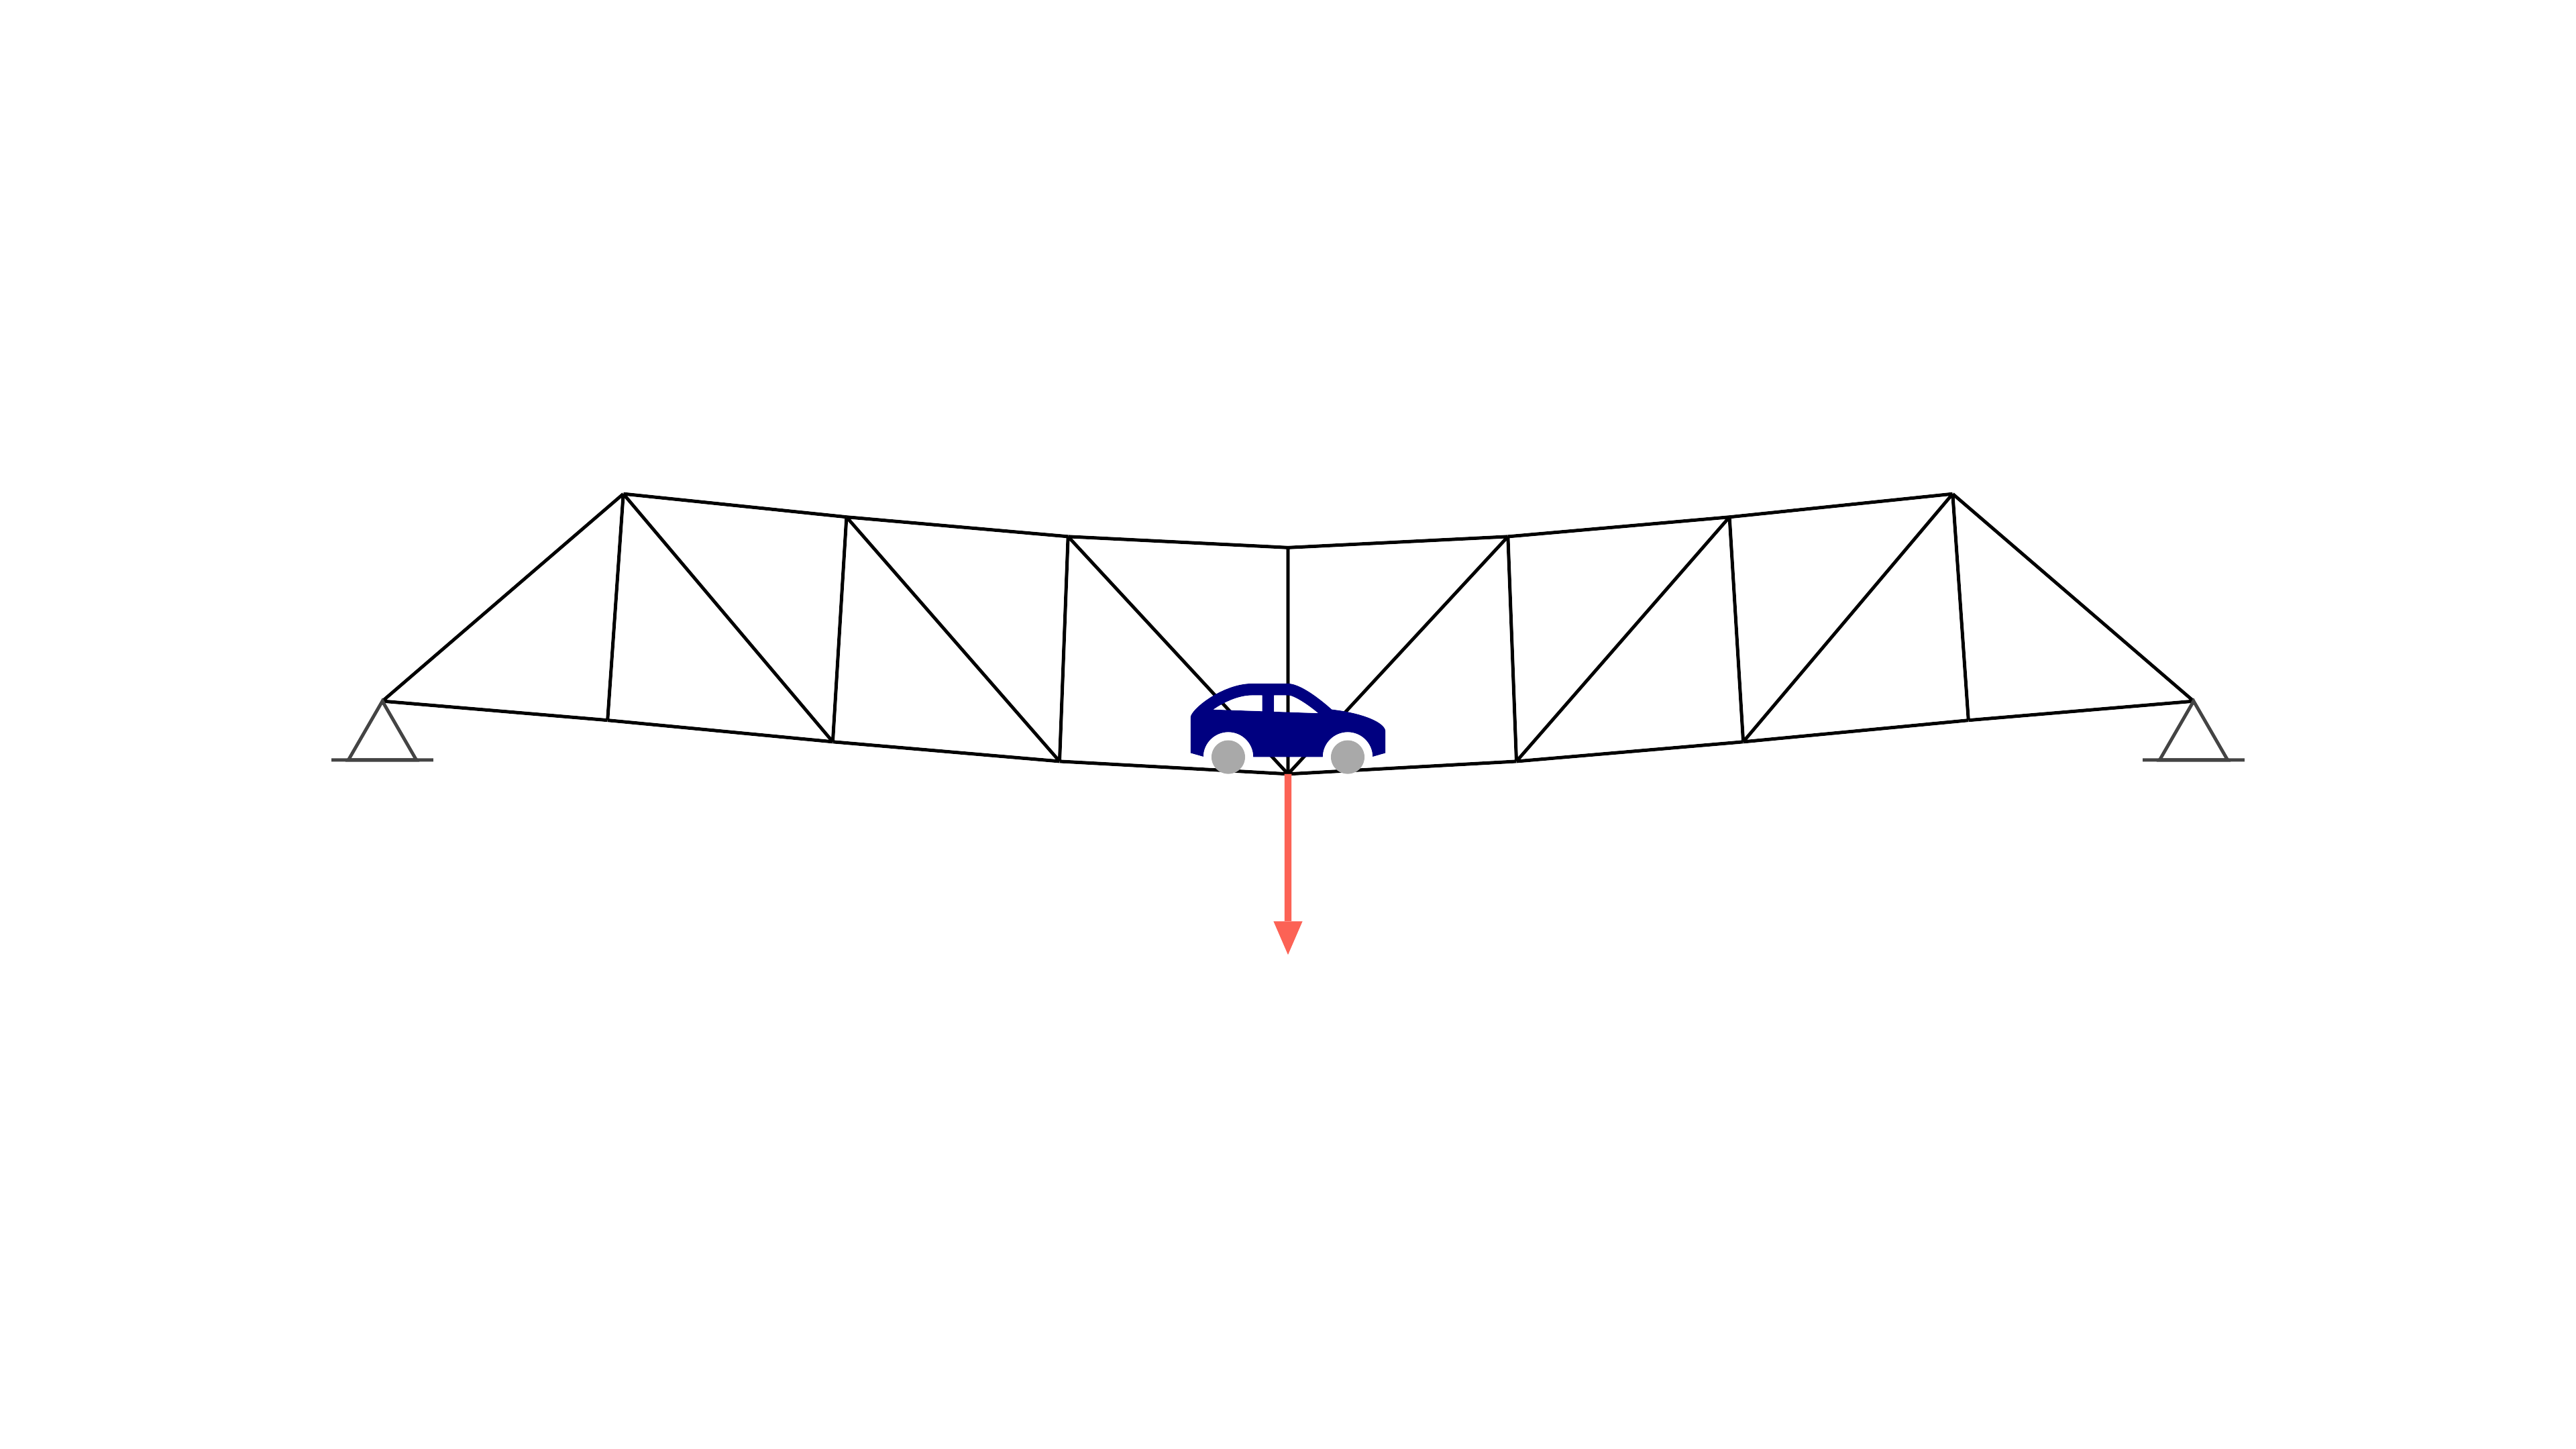

Manim Community v0.19.0

                    WARNING  Output format changed to '.mov' to support transparency                  ]8;id=732947;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=435469;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

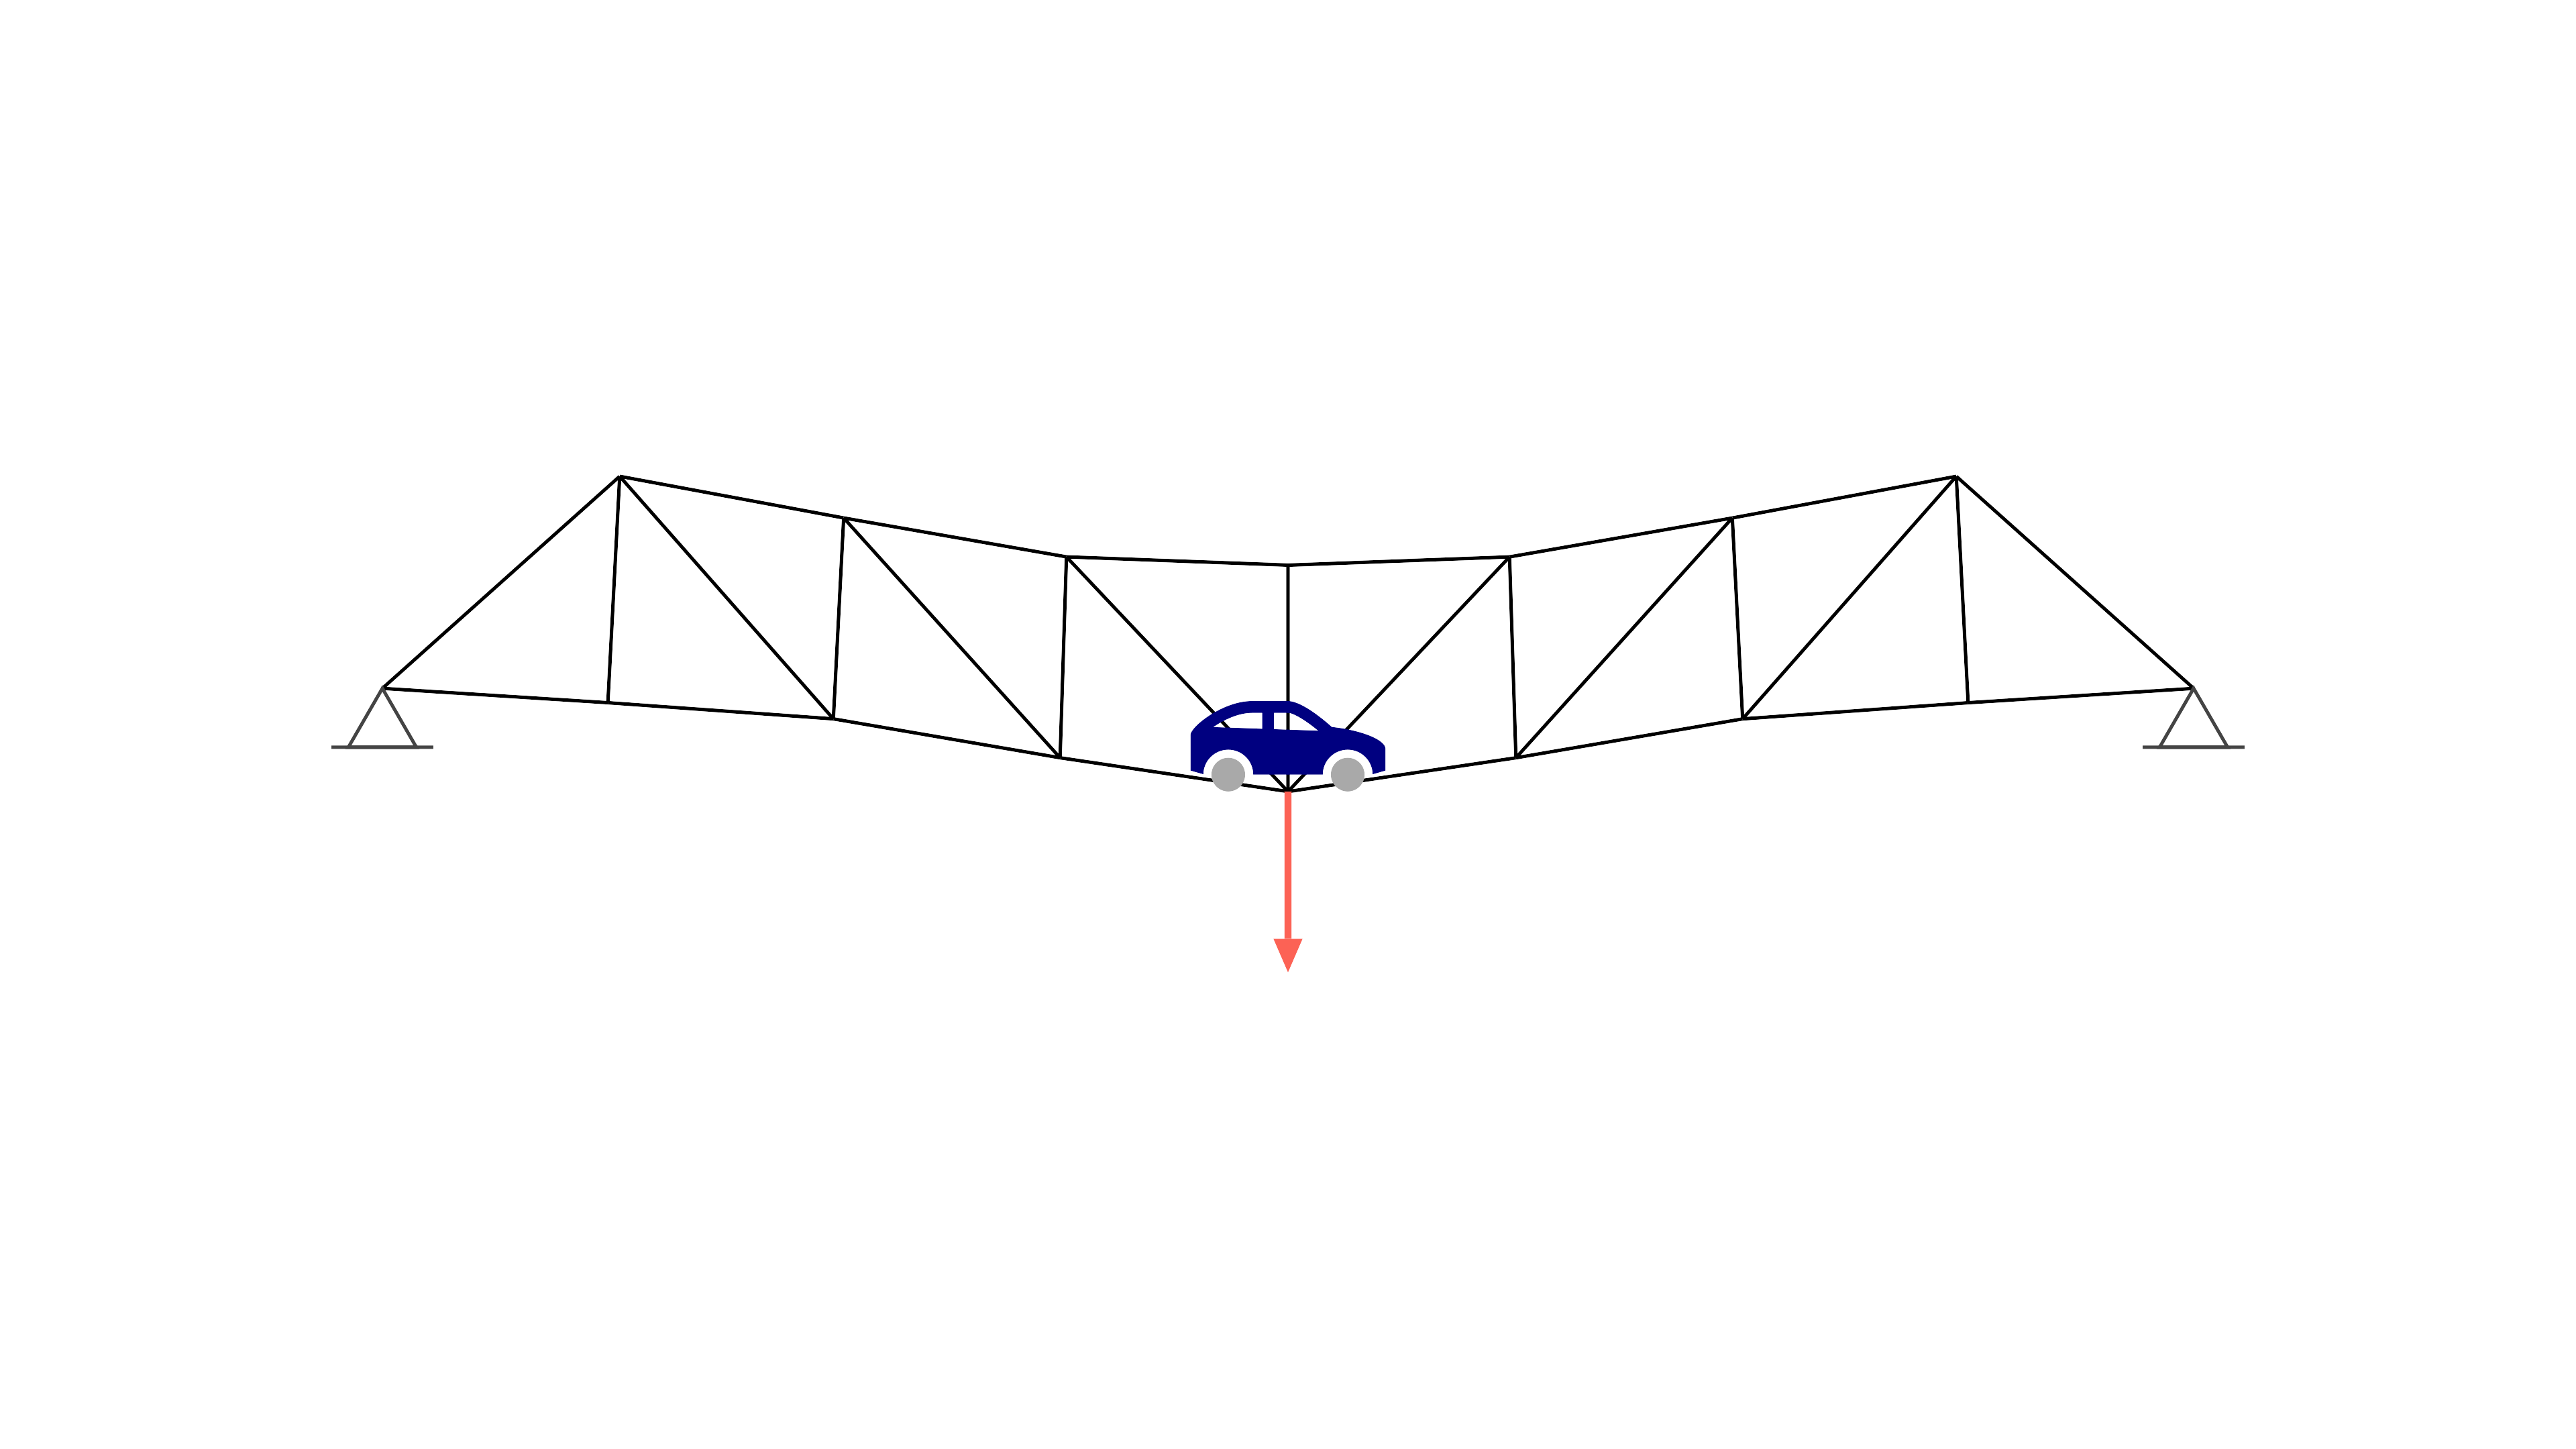

Manim Community v0.19.0

[08/23/25 21:40:11] WARNING  Output format changed to '.mov' to support transparency                  ]8;id=75276;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py\utils.py]8;;\:]8;id=206106;file:///Users/aflamant/miniconda3/envs/x86manim/lib/python3.12/site-packages/manim/_config/utils.py#1435\1435]8;;\

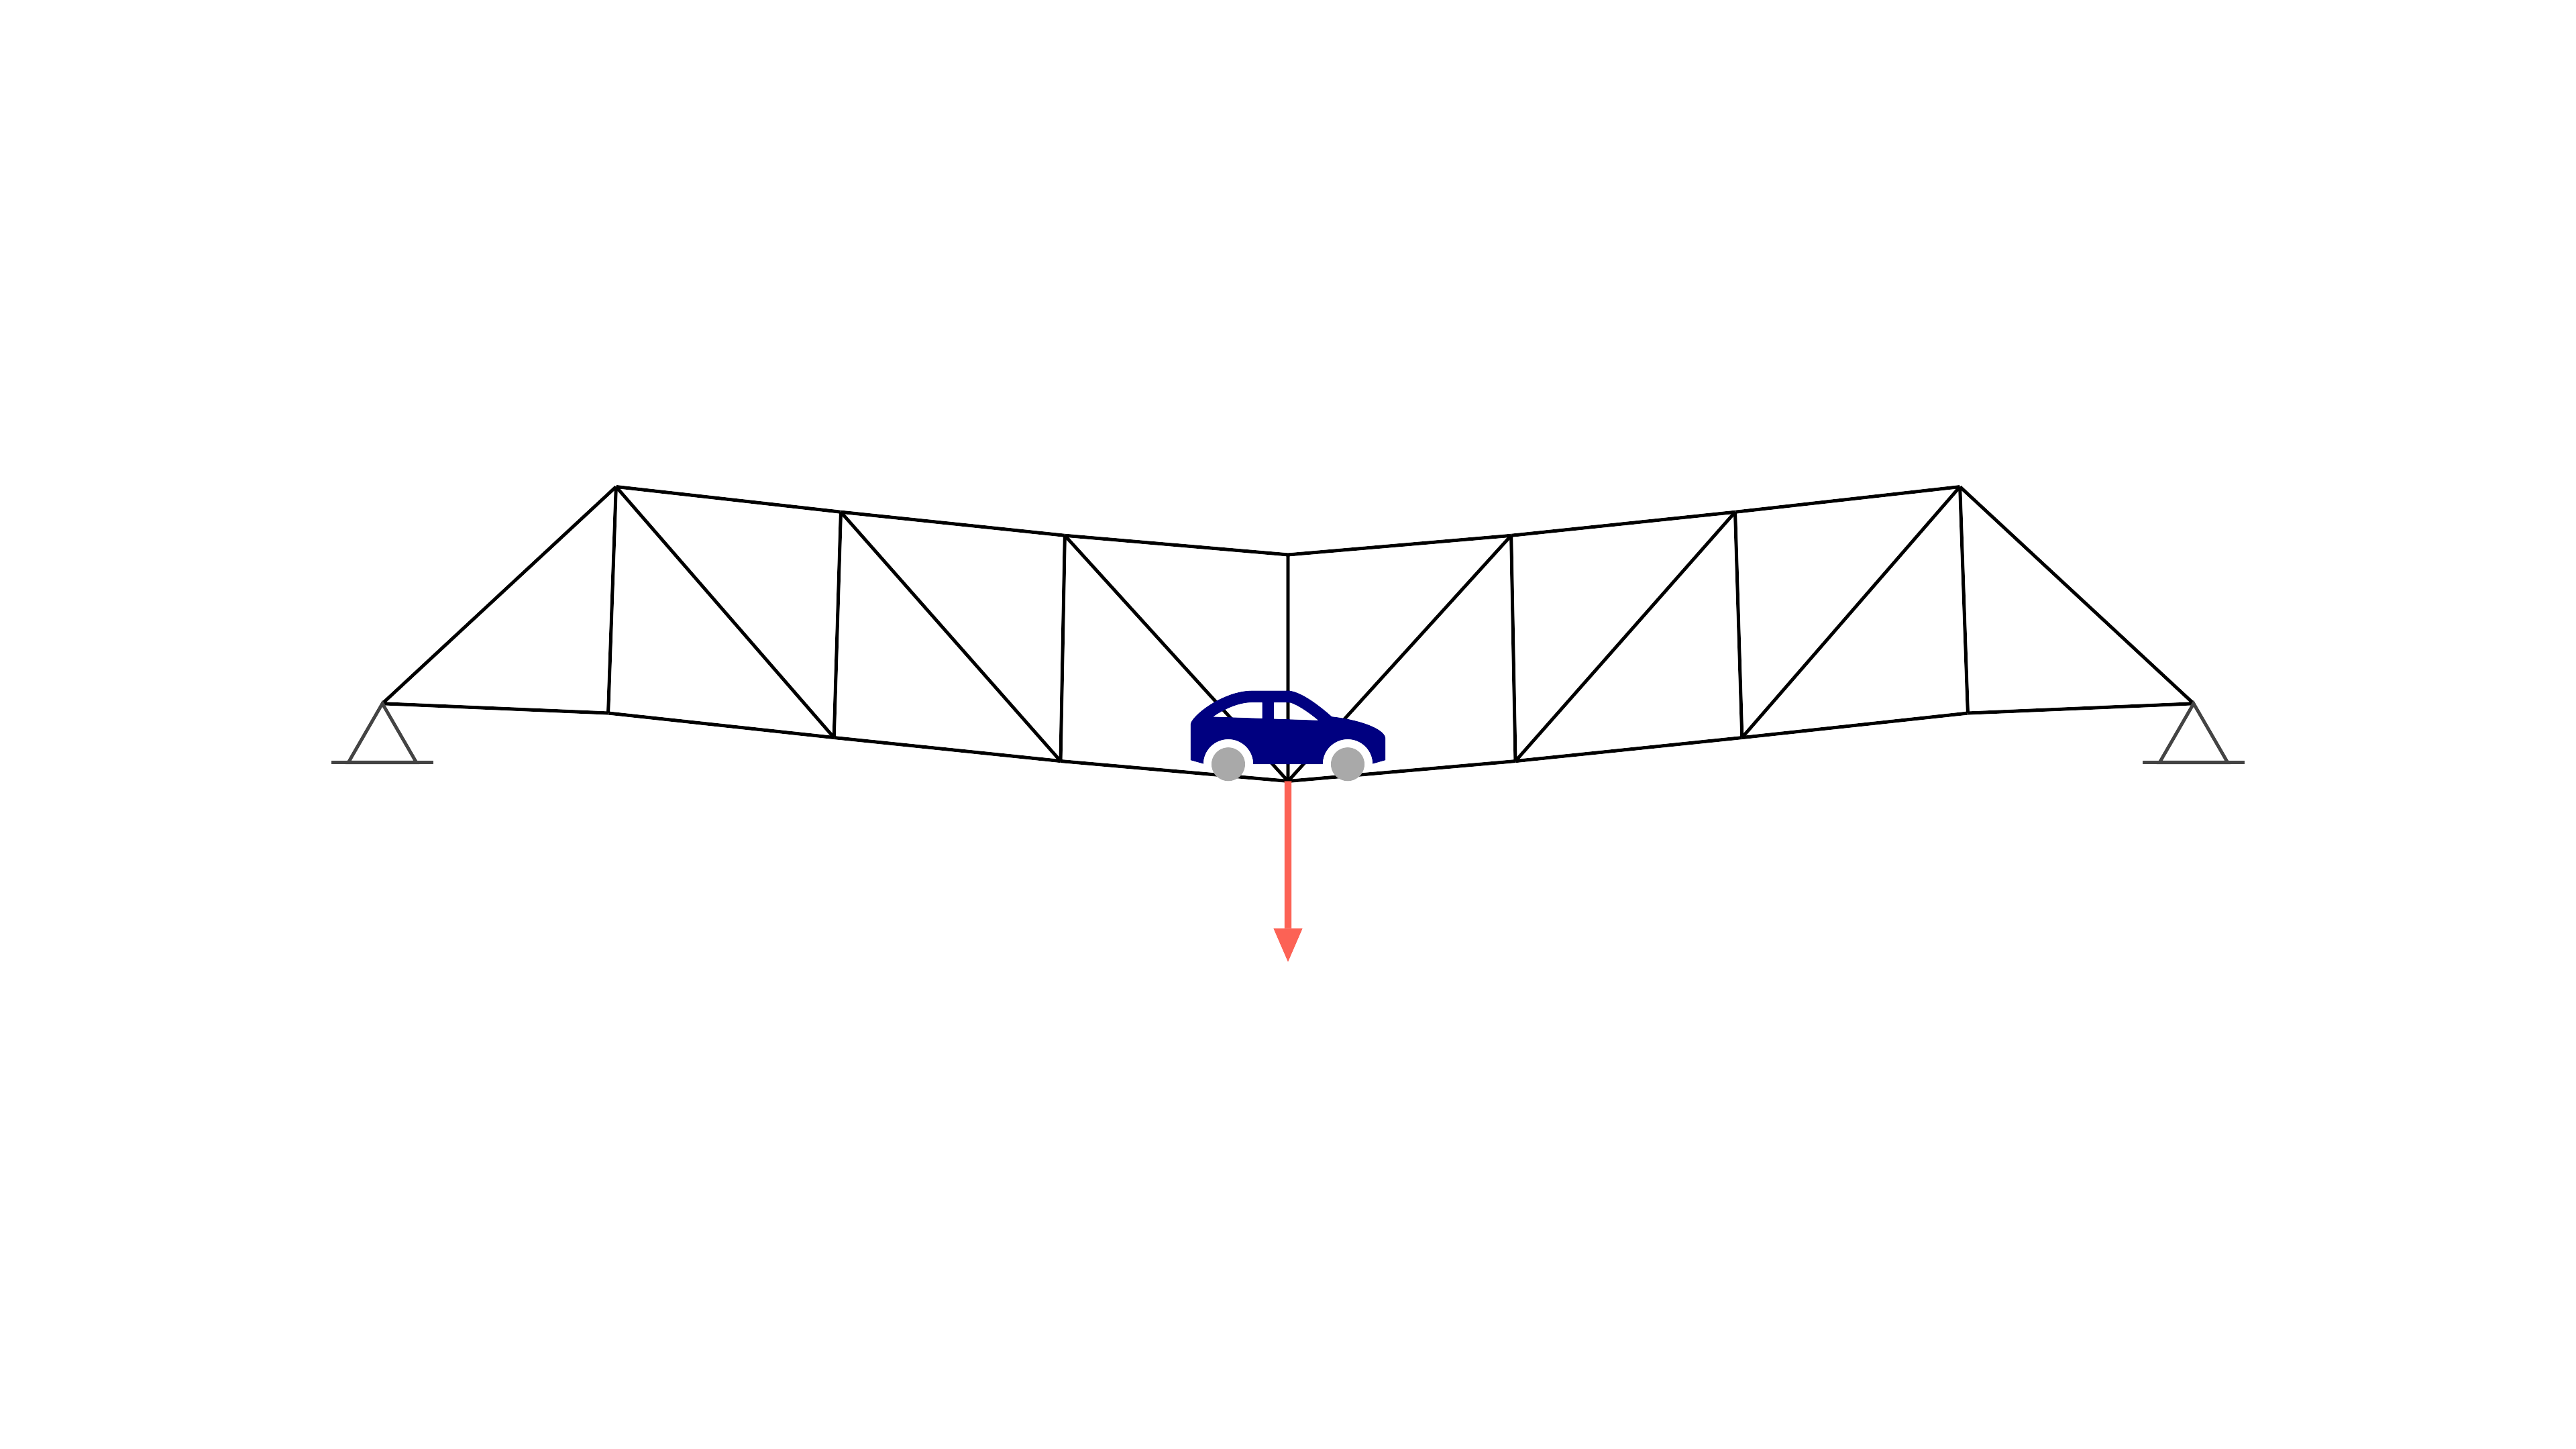

In [12]:
class Deformation1(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(2)
        self.camera.frame.move_to(ORIGIN)
        self.scale = 200

    def construct(self):
        nodes = np.array(
            [(0, 0, 0), (5, 0, 0), (10, 0, 0), (15, 0, 0), (20, 0, 0), (25, 0, 0), (30, 0, 0), (35, 0, 0), (40, 0, 0),
             (35, 5, 0), (30, 5, 0), (25, 5, 0), (20, 5, 0), (15, 5, 0), (10, 5, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 8: (True, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8),
                                        (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 0),
                                        (1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9),
                                        (2, 15), (3, 14), (4, 13), (4, 11), (5, 10), (6, 9)])
        loads = {
            #3: [0, -500e3],
            4: [0., -1500e3],
            #5: [0., -500e3],
        }

        A = [.1] * len(connectivity_matrix)
        E = [210.e9] * len(connectivity_matrix)

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
        N = N.round(0)
        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_color': BLACK, 'stroke_width': 4},
                  node_style={'radius': 0, 'color': DARK_GRAY},
                  support_style={'height': 1.3, 'color': DARK_GRAY},
                  load_style={'scale': 4, 'stroke_width': 8},
                  tip_style={'tip_length': .75, 'tip_width': .65},
                  deformed_style={'dash_length': .25, 'stroke_width': 8},
                  display_node_labels=False,
                  display_load_labels=False,
                  display_member_labels=False)

        g.move_to(ORIGIN)

        car = SVGMobject("figures/ref_img/car.svg")
        car.scale(2 / car.height)
        car.next_to(g.nodes[4], UP, buff=0)
        car.add_updater(lambda m: m.next_to(g.nodes[4], UP, buff=0))
        g.deform_structure(self.scale, False)
        g.update()
        car.update()

        self.add(g, car)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(.5)

        path = f"deformation_classic.svg"
        all_group.to_svg(path, crop=True)

class Deformation2(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(2)
        self.camera.frame.move_to(ORIGIN)
        self.scale = 150

    def construct(self):
        nodes = np.array(
            [(0, 0, 0), (5, 0, 0), (10, 0, 0), (15, 0, 0), (20, 0, 0), (25, 0, 0), (30, 0, 0), (35, 0, 0), (40, 0, 0),
             (35, 5, 0), (30, 5, 0), (25, 5, 0), (20, 5, 0), (15, 5, 0), (10, 5, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 8: (True, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8),
                                        (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 0),
                                        (1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9),
                                        (2, 15), (3, 14), (4, 13), (4, 11), (5, 10), (6, 9)])
        loads = {
            #3: [0, -500e3],
            4: [0., -1500e3],
            #5: [0., -500e3],
        }

        A = [.1] * len(connectivity_matrix)
        E = np.array([210.e9] * len(connectivity_matrix))
        E[[16, 17, 18, 19, 20, 21, 22]]= 10e9

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
        N = N.round(0)
        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_color': BLACK, 'stroke_width': 4},
                  node_style={'radius': 0, 'color': DARK_GRAY},
                  support_style={'height': 1.3, 'color': DARK_GRAY},
                  load_style={'scale': 4, 'stroke_width': 8},
                  tip_style={'tip_length': .75, 'tip_width': .65},
                  deformed_style={'dash_length': .25, 'stroke_width': 8},
                  display_node_labels=False,
                  display_load_labels=False,
                  display_member_labels=False)

        g.move_to(ORIGIN)

        car = SVGMobject("figures/ref_img/car.svg")
        car.scale(2 / car.height)
        car.next_to(g.nodes[4], UP, buff=0)
        car.add_updater(lambda m: m.next_to(g.nodes[4], UP, buff=0))
        g.deform_structure(self.scale, False)
        g.update()
        car.update()

        self.add(g, car)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(.5)

        path = f"deformation_vertical.svg"
        all_group.to_svg(path, crop=True)

class Deformation3(MovingCameraScene):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.camera.frame.scale(2)
        self.camera.frame.move_to(ORIGIN)
        self.scale = 100

    def construct(self):
        nodes = np.array(
            [(0, 0, 0), (5, 0, 0), (10, 0, 0), (15, 0, 0), (20, 0, 0), (25, 0, 0), (30, 0, 0), (35, 0, 0), (40, 0, 0),
             (35, 5, 0), (30, 5, 0), (25, 5, 0), (20, 5, 0), (15, 5, 0), (10, 5, 0), (5, 5, 0)], dtype=float)
        supports = {0: (True, True), 8: (True, True)}
        connectivity_matrix = np.array([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8),
                                        (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 0),
                                        (1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9),
                                        (2, 15), (3, 14), (4, 13), (4, 11), (5, 10), (6, 9)])
        loads = {
            #3: [0, -500e3],
            4: [0., -1500e3],
            #5: [0., -500e3],
        }

        A = [.1] * len(connectivity_matrix)
        E = np.array([210.e9] * len(connectivity_matrix))
        E[23:]= 30e9

        u, N = analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A, E)
        N = N.round(0)
        font_size = 30
        g = Truss(nodes=nodes,
                  connectivity_matrix=connectivity_matrix,
                  supports=supports,
                  loads=loads,
                  displacements=u,
                  member_style={'stroke_color': BLACK, 'stroke_width': 4},
                  node_style={'radius': 0, 'color': DARK_GRAY},
                  support_style={'height': 1.3, 'color': DARK_GRAY},
                  load_style={'scale': 4, 'stroke_width': 8},
                  tip_style={'tip_length': .75, 'tip_width': .65},
                  deformed_style={'dash_length': .25, 'stroke_width': 8},
                  display_node_labels=False,
                  display_load_labels=False,
                  display_member_labels=False)

        g.move_to(ORIGIN)

        car = SVGMobject("figures/ref_img/car.svg")
        car.scale(2 / car.height)
        car.next_to(g.nodes[4], UP, buff=0)
        car.add_updater(lambda m: m.next_to(g.nodes[4], UP, buff=0))
        g.deform_structure(self.scale, False)
        g.update()
        car.update()

        self.add(g, car)

        all_group = get_all_vmobjects(self)
        all_group.center().scale(.5)

        path = f"deformation_diagonal.svg"
        all_group.to_svg(path, crop=True)

%manim --transparent --format png -qk -v WARNING Deformation1
%manim --transparent --format png -qk -v WARNING Deformation2
%manim --transparent --format png -qk -v WARNING Deformation3